## The basic steps for a classification task using GridSearchCV

### step-1:  load data and clean data ( handle missing values)

In [1]:
#drop or interpolate using Pandas

### step-2: preprocess data

In [2]:
#normalization, reshape, etc

Let's generate some random data, so we can discuss the next steps 

In [3]:
#random number generator
import numpy as np
rng=np.random.RandomState(0)

In [4]:
num_samples=3000
num_features=5
num_classes=3

In [5]:
X0=rng.rand(num_samples//3, num_features) #class-0: x in range of [0, 1]
Y0=np.zeros(num_samples//3)
X1=0.5+rng.rand(num_samples//3, num_features)  #class-1: x in range of [0.5, 1.5]
Y1=np.ones(num_samples//3)
X2=1+rng.rand(num_samples//3, num_features)  #class-2: x in range of [1, 2]
Y2=2*np.ones(num_samples//3)
X=np.concatenate([X0, X1, X2])
Y=np.concatenate([Y0, Y1, Y2])

In [6]:
print(X0.min(), X0.max())
print(X1.min(), X1.max())
print(X2.min(), X2.max())

7.2449638492178e-05 0.9999640185426024
0.5001503810808555 1.4999779517807228
1.0001664413402684 1.9999620173413053


In [7]:
#usually, class label/index starts from 0
Y.min()

0.0

In [8]:
Y.max()

2.0

### step-3: train-validation-test split
analogy <br>
training set: homework <br>
validation set: self-test  <br>
test set:       final exam  <br>

In [9]:
from sklearn.model_selection import train_test_split
#split the data (X,Y) into a training set (X_train, Y_train) and a test set (X_test, Y_test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [10]:
X_train.shape

(2400, 5)

#### split the training set to a 'pure' training set (defined by train_idx) and a validation set  (defined by val_idx)

In [11]:
N_train=int(0.9*X_train.shape[0]) # for 'pure' training

In [12]:
#we only need the indexes and do not need the actual splitting
idx_list=np.arange(0, X_train.shape[0])
rng.shuffle(idx_list)
train_idx=idx_list[0:N_train]
val_idx=idx_list[N_train:]

#### If there is class-imblance, then we have two options:
(1) using class-weight <br>
        `class-weight='balanced'` if the classifier has a hyper-parameter named `class-weight` <br>
(2) resampling the training dataset <br>
        `train_idx=resample(train_idx[Y_train==k], n_samples=????) for class-k`                
We will use class-weight for random forest and use resampling for KNN

### step-4: choose a machine learning model

In [13]:
from sklearn.ensemble import RandomForestClassifier
# model =RandomForestClassifier(n_estimators=???)

### step-5: find the optimal parameter(s) of the model using training-validation

In [14]:
#create a dictionary of model hyper-parameter(s)
# if the goal is to optimize one hyper-parameter: n_estimators, then
#create a list of possible values of the parameter n_estimators
n_list=np.arange(1, 100, 5)
param_grid = {'n_estimators':n_list}

In [15]:
#if the goal is to optimize multiple hyper-parameters of random forest, then:
#param_grid={'max_depth': list1,          # list1=[1, 10, 100]
#            'min_samples_split': list2,  # list2=[2, 5, 10]
#            'min_samples_leaf':list3,    # list3=[1, 5, 10]
#            'max_features':list4,        # list4=["sqrt", "log2", None]
#            'max_samples':list5,         # list5=[0.1, 0.5, 0.9]
#            'class_weight':['balanced'], # to handle class-imbalance: always set class_weight to 'balanced' 
#            'n_estimators':n_list        # n_list=[1, 20, 100] or just [20]
#             }
#you could expand the search range for each parameter in this param_grid

In [16]:
from sklearn.metrics import confusion_matrix

def weighted_accuracy(confusion):
    #input: confusion is the confusion matrix
    #output: acc is the weighted classification accuracy
    M=confusion.copy().astype('float32')
    for k in range(0, M.shape[0]):
        M[k]/=M[k].sum()+1e-8    
    acc = M.diagonal().sum()/M.sum()
    return acc

def my_scorer(model, X, Y_true):
    Y_pred = model.predict(X)
    confusion=confusion_matrix(Y_true, Y_pred)
    acc=weighted_accuracy(confusion)
    return acc

In [17]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(estimator=RandomForestClassifier(),
                  param_grid=param_grid,
                  #scoring='accuracy', # it will calculate standard accuracy for training and validation
                  scoring=my_scorer,
                  cv=[(train_idx, val_idx)])
#set cv=[(train_idx, val_idx)], then it will only do train-validation once
#set cv=5, then it will do 5-fold cross-validation

`scoring` is 'accuracy': the best model has the highest classification accuracy <br>
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [18]:
# do training and validation
gs.fit(X_train, Y_train) 
#here, (X_train, Y_train) contain the "pure" training data and the validation data

GridSearchCV(cv=[(array([1476,  163,  820, ..., 1685, 2105,  242]),
                  array([ 975, 1318, 2085, 2026,  170, 1783, 2078, 1763, 1283,  450, 1152,
       1095,  754, 1784, 1732, 1456,  293, 2316,  373, 1267, 1250, 2350,
       1380,  787,  453, 1285,  324, 2399, 1971, 2235,  666, 2236, 1328,
        122,  748,  290,  333,  247,  375,  218, 1058, 2320, 1253,  424,
        781,  770, 1605, 1517, 1535,  794, 1881,   66, 1540, 1883,  225,
       1848, 1660,  210, 1886, 1505, 1961, 1128,...
       1917,   55,  714,  509, 1004, 1820, 1248, 1591,  951, 2021, 2227,
        498, 1411, 1255, 1334, 2019,  664,  790, 1367, 1462, 1921, 1204,
       1604, 2173, 1692,  838,  159, 1722,  752,  663, 2043, 1955, 1451,
        241, 1145,  239, 1501, 2048,  492, 1160, 1137,  329]))],
             estimator=RandomForestClassifier(),
             param_grid={'n_estimators': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
       86, 91, 96])},
             scoring=<func

In [19]:
gs.cv_results_

{'mean_fit_time': array([0.00405669, 0.01413989, 0.0243535 , 0.03569889, 0.04670739,
        0.05659461, 0.0677669 , 0.07630301, 0.08626986, 0.09862494,
        0.10975814, 0.1191175 , 0.13117623, 0.14846301, 0.16426229,
        0.15989923, 0.17165399, 0.18159795, 0.1910665 , 0.20403337]),
 'std_fit_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 'mean_score_time': array([0.00199652, 0.00216866, 0.00199533, 0.00196648, 0.00199461,
        0.0029943 , 0.00302052, 0.00398922, 0.00399065, 0.00417542,
        0.00501513, 0.00514674, 0.004987  , 0.00602603, 0.00598407,
        0.00598407, 0.00616693, 0.00611067, 0.00712395, 0.00816965]),
 'std_score_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 'param_n_estimators': masked_array(data=[1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66,
                    71, 76, 81, 86, 91, 96],
              mask=[False, False, False, Fals

In [20]:
# accuracy on validation set
acc_val_list=gs.cv_results_['mean_test_score']
acc_val_list

array([0.97098392, 0.96696788, 0.97113448, 0.97499996, 0.97515059,
       0.97098392, 0.97098392, 0.97515059, 0.98348397, 0.97098392,
       0.97098392, 0.97098392, 0.97098392, 0.97098392, 0.97098392,
       0.97098392, 0.97098392, 0.97515059, 0.97515059, 0.97098392])

Text(0, 0.5, 'accuracy')

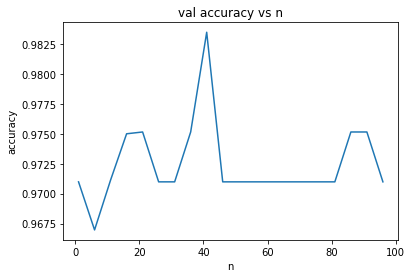

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(n_list, acc_val_list)
ax.set_title('val accuracy vs n')
ax.set_xlabel('n')
ax.set_ylabel('accuracy')

In [22]:
# the best parameter leads to the highest classification accuracy on the validation set
n_best=n_list[np.argmax(acc_val_list)]
n_best

41

In [23]:
#we can directly get the best parameter(s)
gs.best_params_ 


{'n_estimators': 41}

In [24]:
#we could train the model again using the best parameter(s)
#   model_best=RandomForestClassifier(n_estimators=n_best)
#   model_best.fit(X_train, Y_train)
#we can directly use gs.best_estimator_
#it is the best model
model_best=gs.best_estimator_
model_best

RandomForestClassifier(n_estimators=41)

In [25]:
#measure the classification accuracy on the training set
acc_train=model_best.score(X_train, Y_train)
acc_train

1.0

### step-6: evaluate the model on the test set (the "final exam")

In [26]:
#measure the classification accuracy on the test set
acc_test=model_best.score(X_test, Y_test)
acc_test

0.9783333333333334

In [27]:
#if there is class-imbalance, we need to use weighted accuracy
acc_test_weighted=my_scorer(model_best, X_test, Y_test)
acc_test_weighted

0.97671574